In [1]:
import random
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.nn import UpsamplingNearest2d
from torch.nn.utils import spectral_norm
from torch.distributions import Normal
import torch
from pathlib import Path
from torch import nn
import pdb
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
#import u_net
import utils
import glob
from torchvision.io import read_image
import os
from torchvision.models import vgg16
import torchvision.transforms as T
import torch
import os
import vae
from torch.utils.data import DataLoader
import numpy as np
import GAN
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchsummary import summary

### Helpfull sources?
https://opengtn.eu/wp-content/uploads/2022/02/Amirrajab_Intra-and-intersubject-synthesis-of-cardiac-MR-images-using-a-VAE-and-GAN-ISMRM2022.pdf  

https://notebook.community/zklgame/CatEyeNets/test/GANs-PyTorch 

https://www.researchgate.net/figure/Discriminator-networks-architecture-All-convolution-layers-use-zero-padding-set-to-one_fig3_330470286 

Op het moment is het probleem dat de modellen niet goed leren. Dus de loss van de generator begint hoog maar daalt terwijl de loss van de generator juist laag begint en omhoog gaat. Eigenlijk zou je willen dat de loss van de generator juist omlaag gaat en de loss van de discriminator juist omhoog. 

In [2]:
random.seed(42)
DATA_DIR = r"D:\master\TrainingData\TrainingData"
CHECKPOINTS_DIR = Path.cwd() / "vae_model_weights"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR_GAN = "GAN_runs"

In [3]:

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 4 #I think we wanted to generate images on whole dataset so this should be 0?
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32
N_EPOCHS = 10
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-4
DISPLAY_FREQ = 10

# dimension of VAE latent space
Z_DIM = 256

In [4]:
# function to reduce the
def lr_lambda(the_epoch):
    """Function for scheduling learning rate"""
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

In [5]:
patients = [
    path
    for path in glob.glob(DATA_DIR+r"\p*[0-9]")
]

random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

In [6]:
dataset = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

Feature batch shape: torch.Size([32, 1, 64, 64])
Labels batch shape: torch.Size([32, 1, 64, 64])


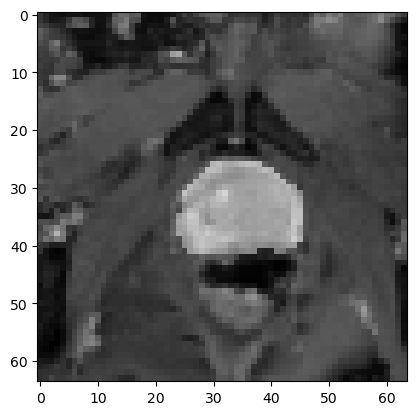

Label: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


In [7]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.imshow(label,cmap='gray',alpha=0.3)
plt.show()
print(f"Label: {label}")

In [8]:
# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [9]:
# # initialise model, optimiser
# vae_model = vae.VAE()
# optimizer = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)
# # add a learning rate scheduler based on the lr_lambda function
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [10]:
# # training loop
# writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)  # tensorboard summary
# for epoch in range(N_EPOCHS):
#     current_train_loss = 0.0
#     current_valid_loss = 0.0

#     for x_real, _ in tqdm(dataloader, position=0):
#         # needed to zero gradients in each iteration
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae_model(x_real)  # forward pass
#         loss = vae.vae_loss(x_real, x_recon, mu, logvar)
#         current_train_loss += loss.item()
#         loss.backward()  # backpropagate loss
#         optimizer.step()  # update weights

#     # write to tensorboard log
#     writer.add_scalar("Loss/train", current_train_loss / len(dataloader), epoch)

#     scheduler.step()  # step the learning step scheduler

#     # save examples of real/fake images
#     if (epoch + 1) % 1 == 0:
#         vae_model.eval()
#         img_grid = make_grid(
#             torch.cat((x_recon[:5], x_real[:5])), nrow=5, padding=12, pad_value=-1
#         )
#         writer.add_image(
#             "Real/fake_recon",
#             np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
#             epoch + 1,
#         )

#         noise = torch.randn(10, Z_DIM)
#         image_samples = vae_model.generator(noise)
#         img_grid = make_grid(
#             torch.cat((image_samples[:5], image_samples[5:])),
#             nrow=5,
#             padding=12,
#             pad_value=-1,
#         )
#         writer.add_image(
#             "Samples",
#             np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
#             epoch + 1,
#         )

#     vae_model.train()


# torch.save(vae_model.state_dict(), CHECKPOINTS_DIR / "vae_model.pth")

In [11]:
%load_ext tensorboard
%tensorboard --logdir='vae_runs'

### GAN TRAINING

In [12]:
# class GANLoss(nn.Module):
#     def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0,
#                  tensor=torch.FloatTensor):
#         super().__init__()
#         self.real_label = target_real_label
#         self.fake_label = target_fake_label
#         self.real_label_var = None
#         self.fake_label_var = None
#         self.Tensor = tensor
#         if use_lsgan:
#             self.loss = nn.L1Loss()
#         else:
#             self.loss = nn.BCELoss()

#     def get_target_tensor(self, input, target_is_real):
#         target_tensor = None
#         if target_is_real:
#             create_label = ((self.real_label_var is None) or
#                             (self.real_label_var.numel() != input.numel()))
#             if create_label:
#                 real_tensor = self.Tensor(input.size()).fill_(self.real_label)
#                 self.real_label_var = torch.tensor(real_tensor, requires_grad=False)
#             target_tensor = self.real_label_var
#         else:
#             create_label = ((self.fake_label_var is None) or
#                             (self.fake_label_var.numel() != input.numel()))
#             if create_label:
#                 fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
#                 self.fake_label_var = torch.tensor(fake_tensor, requires_grad=False)
#             target_tensor = self.fake_label_var
#         return target_tensor

#     def __call__(self, input, target_is_real):        
#         target_tensor = self.get_target_tensor(input, target_is_real)
#         return self.loss(input,target_tensor.to(torch.device('cpu')))

### GAN loss

In [13]:
# https://notebook.community/zklgame/CatEyeNets/test/GANs-PyTorch
#https://www.researchgate.net/figure/Figure-S36-The-label-input-method-for-the-generator-in-CcGAN_fig5_348834209
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [14]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    real_loss = bce_loss(logits_real, 1)
    fake_loss = bce_loss(logits_fake, 0)
    loss = real_loss*0.5 + fake_loss #Have a look at this ? correct?
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    loss = bce_loss(logits_fake, 1)
    return loss

In [15]:
# answers = np.load(r'C:\Users\20181758\Documents\gan-checks-tf.npz')
# dtype = torch.FloatTensor
# from torch.autograd import Variable

# def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
#     d_loss = discriminator_loss(Variable(torch.Tensor(logits_real)).type(dtype),
#                                 Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
#     print("Maximum error in d_loss: %g", abs(1-(d_loss_true/ d_loss)))
# 
# test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
#                         answers['d_loss_true'])

In [16]:
# def test_generator_loss(logits_fake, g_loss_true):
#     g_loss = generator_loss(Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
#     print("Maximum error in g_loss: %g", 1-g_loss_true/ g_loss)

# test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:

epochs = 10
lr_gen = 0.0001
lr_dis = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True

gen = GAN.Generator()
dis = GAN.Discriminator()

gen = gen.to(device)
dis = dis.to(device)

noise = torch.randn(32, 256)
noise = noise.to(device)


gen.apply(weights_init)
dis.apply(weights_init)

optim_gen = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr=lr_dis, betas=(0.5, 0.999))

In [19]:

# add a learning rate scheduler based on the lr_lambda function
scheduler = torch.optim.lr_scheduler.LambdaLR(optim_gen, lr_lambda)

In [20]:
img_lists = []
G_losses = []
D_losses = []
iters = 0
writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR_GAN)  # tensorboard summary
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    for (img, seg) in tqdm(dataloader):
        img = img.to(device)
        seg = seg.to(device)

        seg=seg.float()
        
        
        fake_img = gen(noise,seg)
        
        # Fake Detection and Loss
        pred_fake = dis(fake_img,seg)
        #loss_D_fake = criterion(pred_fake, False)
        
        # Real Detection and Loss
        pred_real = dis(img,seg)
        #loss_D_real = criterion(pred_real, True)
        
        loss_G = generator_loss(pred_fake)
        loss_D = discriminator_loss(pred_real,pred_fake)
        
        # Backprop
        optim_gen.zero_grad()
        loss_G.backward(retain_graph=True)
        optim_gen.step()
        
        optim_dis.zero_grad()
        loss_D.backward()
        optim_dis.step()
        
        G_losses.append(loss_G.detach().cpu())
        D_losses.append(loss_D.detach().cpu())
        
        # if i%200 == 0:
        #     print("Iteration {}/{} started".format(i+1, len(dataloader)))
    writer.add_scalar("Loss dis", loss_D / len(dataloader), epoch)
    writer.add_scalar("Loss gen", loss_G / len(dataloader), epoch)  
    scheduler.step()   
    print("G_loss= ",loss_G, " : D_Loss= ", loss_D)
    if (epoch + 1) % 1 == 0:
        gen.eval()
        img_grid = make_grid(
            torch.cat((fake_img[:5], img[:5])), nrow=5, padding=12, pad_value=-1
        )
        writer.add_image(
            "Real/fake_recon",
            np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
            epoch + 1,
        )
        
    if epoch%20 == 0:
        with torch.no_grad():
            img_lists.append(fake_img.detach().cpu().numpy())
            
    iters+=1
torch.save(gen.state_dict(), CHECKPOINTS_DIR / "gan.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 1/10 [00:45<06:50, 45.56s/it]

G_loss=  tensor(0.6930, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8500, grad_fn=<AddBackward0>)
Epoch 2/10


 20%|██        | 2/10 [01:31<06:04, 45.55s/it]

G_loss=  tensor(0.6924, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8506, grad_fn=<AddBackward0>)
Epoch 3/10


 30%|███       | 3/10 [02:15<05:15, 45.03s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 4/10


 40%|████      | 4/10 [02:59<04:28, 44.68s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 5/10


 50%|█████     | 5/10 [03:52<03:57, 47.55s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 6/10


 60%|██████    | 6/10 [04:41<03:12, 48.13s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 7/10


 70%|███████   | 7/10 [05:27<02:21, 47.32s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 8/10


 80%|████████  | 8/10 [06:11<01:33, 46.51s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 9/10


 90%|█████████ | 9/10 [06:56<00:45, 45.81s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)
Epoch 10/10


100%|██████████| 10/10 [07:43<00:00, 46.30s/it]

G_loss=  tensor(0.6931, grad_fn=<MeanBackward0>)  : D_Loss=  tensor(0.8498, grad_fn=<AddBackward0>)


In [23]:
%load_ext tensorboard
%tensorboard --logdir='GAN_runs'

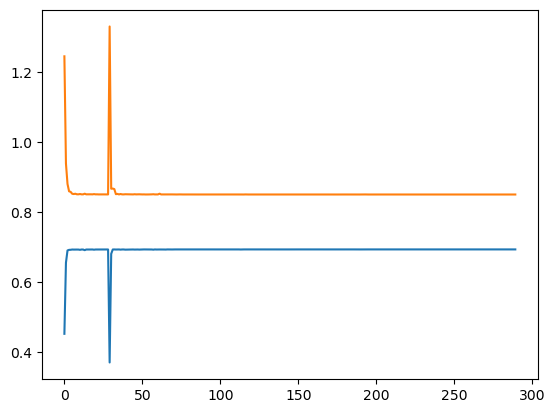

In [24]:
plt.plot(np.arange(0,290),G_losses)
plt.plot(np.arange(0,290),D_losses)

(32, 64, 64)


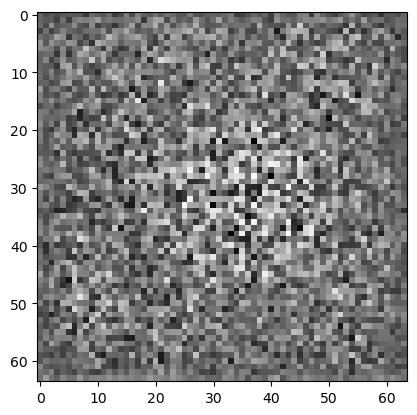

In [27]:

img = img_lists[0].squeeze()
print(img.shape)
plt.imshow(img[5],cmap= 'gray')

In [ ]:
# # training loop
# writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)  # tensorboard summary
# for epoch in range(N_EPOCHS):
#     current_train_loss = 0.0
#     current_valid_loss = 0.0

#     for x_real, _ in tqdm(dataloader, position=0):
#         # needed to zero gradients in each iteration
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae_model(x_real)  # forward pass
#         loss = vae.vae_loss(x_real, x_recon, mu, logvar)
#         current_train_loss += loss.item()
#         loss.backward()  # backpropagate loss
#         optimizer.step()  # update weights

#     # write to tensorboard log
#     writer.add_scalar("Loss/train", current_train_loss / len(dataloader), epoch)

#     scheduler.step()  # step the learning step scheduler

    # save examples of real/fake images
    # if (epoch + 1) % 1 == 0:
    #     vae_model.eval()
    #     img_grid = make_grid(
    #         torch.cat((x_recon[:5], x_real[:5])), nrow=5, padding=12, pad_value=-1
    #     )
    #     writer.add_image(
    #         "Real/fake_recon",
    #         np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
    #         epoch + 1,
    #     )

#         noise = torch.randn(10, Z_DIM)
#         image_samples = vae_model.generator(noise)
#         img_grid = make_grid(
#             torch.cat((image_samples[:5], image_samples[5:])),
#             nrow=5,
#             padding=12,
#             pad_value=-1,
#         )
#         writer.add_image(
#             "Samples",
#             np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
#             epoch + 1,
#         )

#     vae_model.train()


# torch.save(vae_model.state_dict(), CHECKPOINTS_DIR / "vae_model.pth")

In [ ]:
print(1%50)

1


In [ ]:
# import torch
# import torch.nn as nn
# from torch.nn.functional import leaky_relu, interpolate
# from torch.nn.utils import spectral_norm
# import numpy as np
# l1_loss = torch.nn.L1Loss()


# class Block(nn.Module):
#     """
#     Class for the basic convolutional building block
#     """

#     def __init__(self, in_ch, out_ch):
#         """
#         Constructor.
#         :param in_ch: number of input channels to the block
#         :param out_ch: number of output channels of the block
#         """
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#         self.relu = nn.LeakyReLU(0.2, inplace=True)  # leaky ReLU
#         self.bn1 = nn.BatchNorm2d(out_ch)  # batch normalisation
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_ch) #0.8 weghalen

#     def forward(self, x):
#         """
#         Returns the output of a forward pass of the block
#         :param x: the input tensor
#         :return: the output tensor of the block
#         """
#         # a block consists of two convolutional layers
#         # with ReLU activations
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.bn1(x)  # batch normalisation
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.bn2(x)

#         return x
    

# class Generator(nn.Module):
#     """
#     Class for the generator part of the GAN.
#     """

#     def __init__(self, z_dim=256, chs=(256, 128, 64, 32), h=8, w=8):
#         """
#         Constructor.
#         :param chs: tuple giving the number of input channels of each block in the decoder
#         """
#         super().__init__()
#         self.chs = chs
#         self.h = h  # height of image at lowest resolution level
#         self.w = w  # width of image at lowest resolution level
#         self.z_dim = z_dim  # dimension of latent space
#         self.proj_z = nn.Linear(
#             self.z_dim, self.chs[0] * self.h * self.w
#         )  # fully connected layer on latent space
#         self.reshape = lambda x: torch.reshape(
#             x, (-1, self.chs[0], self.h, self.w)
#         )  # reshaping

#         self.upconvs = nn.ModuleList(
#             [nn.ConvTranspose2d(chs[i], chs[i], 2, 2) for i in range(len(chs) - 1)]
#         )

#         self.dec_blocks = nn.ModuleList(
#             [Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]
#         )
#         self.proj_o = nn.Sequential(
#             nn.Conv2d(self.chs[-1], 1, kernel_size=3, padding=1),
#             nn.Tanh(),
#         )  # output layer

#     def forward(self, z,seg):
#         """
#         Returns the output of the decoder part of the VAE
#         :param x: input tensor to the generator
#         """
       
#         b, c, h, w = seg.size()
#         x = self.proj_z(z)  # fully connected layer
#         x = self.reshape(x)  # reshape to image dimension
#         seg=interpolate(seg, size=(seg.size(2)//8, seg.size(3)//8), mode='bilinear')
#         print(seg.size())
#         print(x.size())
#         #print(seg.size(),x.size())
#         x=torch.cat((x,seg),dim=0)
#         for i in range(len(self.chs) - 1):
#             x = self.upconvs[i](x)
#             x = self.dec_blocks[i](x)
#         x = self.proj_o(x)  # output layer
#         return x

# # class Generator(nn.Module):
# #     def __init__(self):
# #         super(Generator, self).__init__()


# #         def block(in_feat, out_feat, normalize=True):
# #             layers = [nn.Linear(in_feat, out_feat)]
# #             if normalize:
# #                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
# #             layers.append(nn.LeakyReLU(0.2, inplace=True))
# #             return layers

# #         self.model = nn.Sequential(
# #             *block(256, 128, normalize=False),
# #             *block(128, 256),
# #             nn.Linear(32, 256*8*8),
# #             nn.Tanh())
# #         self.reshape = lambda x: torch.reshape(
# #             x, (32, -1, 8, 8)
# #         )  # reshaping


# #     def forward(self, noise, labels):
# #         # Concatenate label embedding and image to produce input
# #         noise=self.reshape(noise)
# #         print(noise.size())
# #         print(labels.size())
# #         seg=interpolate(labels, size=(labels.size(2)//8, labels.size(3)//8), mode='bilinear')
# #         gen_input = torch.cat((seg, noise), dim=1)
# #         img = self.model(gen_input)
# #         img = img.view(img.size(0), (1,64,64))
# #         return img

# # class Generator(nn.Module):
# #     def __init__(self):
# #         super().__init__()
# #         self.model = nn.Sequential(
# #             nn.Linear(256, 256*8*8),
# #             nn.ReLU(),
# #             nn.Linear(64, 128),
# #             nn.ReLU(),
# #             nn.Linear(128, 256),
# #             nn.ReLU(),
# #             nn.Linear(128, 256),
# #             nn.ReLU(),
# #             nn.Linear(128, 256),
# #         )

# #     def forward(self, x):
# #         output = self.model(x)
# #         return output
        
# def custom_model1(in_chan, out_chan):
#     return nn.Sequential(
#         spectral_norm(nn.Conv2d(in_chan, out_chan, kernel_size=(3,3), stride=2, padding=1)),
#         nn.LeakyReLU(inplace=True)
#     )

# def custom_model2(in_chan, out_chan, stride=2):
#     return nn.Sequential(
#         spectral_norm(nn.Conv2d(in_chan, out_chan, kernel_size=(3,3), stride=stride, padding=1)),
#         nn.InstanceNorm2d(out_chan),
#         nn.LeakyReLU(inplace=True)
#     )



# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = custom_model1(32, 64)
#         self.layer2 = custom_model2(64, 128)
#         self.layer3 = custom_model2(128, 256,stride=1)
#         #self.layer4 = custom_model2(256, 512, stride=1)
#         self.inst_norm = nn.InstanceNorm2d(256)
#         self.conv = spectral_norm(nn.Conv2d(256, 1, kernel_size=(3,3), padding=1))
#         # self.out=nn.Sequential(
#         #     self.conv,
#         #     nn.Sigmoid(),
#         # )  # output layer

#         self.out = nn.Sequential(nn.Flatten(1), nn.Linear(256,1), nn.Sigmoid())
#     def forward(self, img, seg):
#        # x = torch.cat((img.view(img.size(0), -1),
#                           #seg.view(seg.size(0), -1)), dim=1)
#         x = torch.cat(( img.detach(),seg.detach()), dim=1)
#         x = x.view(-1, 32, 64, 64)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         #x = self.layer4(x)
#         x = leaky_relu(self.inst_norm(x))
#         x = self.out(x)
#         return x
    

# def get_noise(n_samples, z_dim, device="cpu"):
#     """
#     Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
#     creates a tensor of that shape filled with random numbers from the normal distribution.
#     Parameters:
#         n_samples: the number of samples to generate, a scalar
#         z_dim: the dimension of the noise vector, a scalar
#         device: the device type
#     """
#     return torch.randn(n_samples, z_dim, device=device)


# def sample_z(mu, logvar):
#     """
#     Samples noise vector with reparameterization trick.
#     """
#     eps = torch.randn(mu.size(), device=mu.device).to(mu.dtype)
#     return (logvar / 2).exp() * eps + mu


# def kld_loss(mu, logvar):
#     """
#     Returns KLD loss
#     """
#     return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


# def vae_loss(inputs, recons, mu, logvar):
#     """
#     Returns VAE loss, sum of reconstruction and KLD loss
#     """
#     return l1_loss(inputs, recons) + kld_loss(mu, logvar)
